In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import BSE as bse
bse.verbose = False 

print("Imports OK, BSE loaded. verbose =", bse.verbose)


def make_smith_like_schedule(n_periods=6,
                             period_length=60,
                             pre_eq_price=60,
                             post_eq_price=80,
                             spread=40,
                             interval=1):

    total_time = n_periods * period_length
    t_pre_end = 3 * period_length

    pre_min = pre_eq_price - spread
    pre_max = pre_eq_price + spread
    post_min = post_eq_price - spread
    post_max = post_eq_price + spread

    supply_schedule = [
        {
            'from': 0,
            'to': t_pre_end,
            'ranges': [(pre_min, pre_max)],
            'stepmode': 'fixed',
        },
        {
            'from': t_pre_end,
            'to': total_time,
            'ranges': [(post_min, post_max)],
            'stepmode': 'fixed',
        },
    ]

    demand_schedule = [
        {
            'from': 0,
            'to': t_pre_end,
            'ranges': [(pre_min, pre_max)],
            'stepmode': 'fixed',
        },
        {
            'from': t_pre_end,
            'to': total_time,
            'ranges': [(post_min, post_max)],
            'stepmode': 'fixed',
        },
    ]

    order_schedule = {
        'sup': supply_schedule,
        'dem': demand_schedule,
        'interval': interval,
        'timemode': 'drip-poisson',
    }

    return order_schedule


def make_heterogeneous_trader_spec(n_buyers=25, n_sellers=25):
    """
    Create approximately equal numbers of ZIP, ZIC and SHVR traders
    for both buyers and sellers.
    """

    def split_three(n):
        base = n // 3
        rem = n - 3 * base
        return base + (1 if rem > 0 else 0), \
               base + (1 if rem > 1 else 0), \
               base

    zip_b, zic_b, shvr_b = split_three(n_buyers)
    zip_s, zic_s, shvr_s = split_three(n_sellers)

    trader_spec = {
        'buyers':  [('ZIP', zip_b), ('ZIC', zic_b), ('SHVR', shvr_b)],
        'sellers': [('ZIP', zip_s), ('ZIC', zic_s), ('SHVR', shvr_s)],
        'marketmakers': [],
    }

    return trader_spec


def run_smith_market(sess_id="Q2_SMITH",
                     n_periods=6,
                     period_length=60):


    order_schedule = make_smith_like_schedule(
        n_periods=n_periods,
        period_length=period_length,
        pre_eq_price=60,
        post_eq_price=80,
        spread=40,
        interval=1,
    )

    trader_spec = make_heterogeneous_trader_spec(
        n_buyers=25,
        n_sellers=25,
    )

    starttime = 0.0
    endtime = float(n_periods * period_length)

    dumpfile_flags = {
        'dump_tape': True,
        'dump_strats': False,
        'dump_lobs': False,
        'dump_blotters': False,
        'dump_avgbals': False,
        'dump_summary': False,
    }

    sess_vrbs = {
        'sess_id': False,
        'books': False,
        'trades': False,
        'orders': False,
    }

    _ = bse.market_session(
        sess_id,
        starttime,
        endtime,
        trader_spec,
        order_schedule,
        dumpfile_flags,
        sess_vrbs,
    )

    tape_file1 = f"{sess_id}_transactions.csv"
    tape_file2 = f"{sess_id}_tape.csv"

    if os.path.exists(tape_file1):
        tape_file = tape_file1
    elif os.path.exists(tape_file2):
        tape_file = tape_file2
    else:
        print("No tape CSV file found.")
        return pd.DataFrame(columns=['time', 'price', 'txn']), {
            'n_periods': n_periods,
            'period_length': period_length,
            'pre_eq_price': 60,
            'post_eq_price': 80,
        }

    # 4) robust parsing: try to find numeric columns for time and price
    df = pd.read_csv(tape_file, comment='#', header=None)
    df_num = df.apply(pd.to_numeric, errors='coerce')

    numeric_cols = [c for c in df_num.columns if df_num[c].notna().any()]

    if len(numeric_cols) < 2:
        print("Warning: could not find two numeric columns in tape file.")
        return pd.DataFrame(columns=['time', 'price', 'txn']), {
            'n_periods': n_periods,
            'period_length': period_length,
            'pre_eq_price': 60,
            'post_eq_price': 80,
        }

    time_col = numeric_cols[0]
    price_col = numeric_cols[1]

    tape_df = df_num[[time_col, price_col]].copy()
    tape_df.columns = ['time', 'price']
    tape_df = tape_df.dropna(subset=['time', 'price']).reset_index(drop=True)

    if not tape_df.empty:
        tape_df = tape_df.sort_values('time').reset_index(drop=True)
        tape_df['txn'] = np.arange(1, len(tape_df) + 1)
    else:
        tape_df['txn'] = []

    cfg = {
        'n_periods': n_periods,
        'period_length': period_length,
        'pre_eq_price': 60,
        'post_eq_price': 80,
    }

    return tape_df, cfg



def get_smith_market_with_trades(max_tries=15):
  
    for i in range(max_tries):
        sess_id = f"Q2_SMITH_{i}"
        tape_df, cfg = run_smith_market(sess_id=sess_id)

        if not tape_df.empty:
            print(f"Found a run with {len(tape_df)} trades on attempt {i+1} (sess_id={sess_id})")
            return tape_df, cfg
        else:
            print(f"Attempt {i+1}: no trades, trying again...")

    print(f"Tried {max_tries} runs and still no trades.")
    return tape_df, cfg



def plot_supply_demand(pre_eq=60, post_eq=80, spread=40, q_max=30):
    """
    Simple linear supply/demand curves before and after the shock.
    """
    pre_min, pre_max = pre_eq - spread, pre_eq + spread
    post_min, post_max = post_eq - spread, post_eq + spread

    q = np.linspace(0, q_max, 50)

    pre_demand = pre_max - (pre_max - pre_min) * (q / q_max)
    pre_supply = pre_min + (pre_max - pre_min) * (q / q_max)

    post_demand = post_max - (post_max - post_min) * (q / q_max)
    post_supply = post_min + (post_max - post_min) * (q / q_max)

    fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

    ax = axes[0]
    ax.plot(q, pre_demand, label='Demand')
    ax.plot(q, pre_supply, label='Supply')
    ax.axhline(y=pre_eq, color='black', linestyle='dotted', linewidth=1)
    ax.set_title("Before shock")
    ax.set_xlabel("Quantity")
    ax.set_ylabel("Price")
    ax.legend()

    ax = axes[1]
    ax.plot(q, post_demand, label='Demand')
    ax.plot(q, post_supply, label='Supply')
    ax.axhline(y=post_eq, color='black', linestyle='dotted', linewidth=1)
    ax.set_title("After shock")
    ax.set_xlabel("Quantity")
    ax.legend()

    plt.tight_layout()
    plt.show()


def plot_transaction_prices(tape_df, cfg):

    if tape_df is None or tape_df.empty:
        print("No trades recorded in this run – cannot plot transaction prices.")
        return

    n_periods = cfg['n_periods']
    period_length = cfg['period_length']
    pre_eq = cfg['pre_eq_price']
    post_eq = cfg['post_eq_price']

    plt.figure(figsize=(8, 4))

    plt.plot(tape_df['txn'], tape_df['price'],
             marker='o', linestyle='-', linewidth=1, markersize=3)

    for p in range(1, n_periods):
        t_boundary = p * period_length
        diffs = (tape_df['time'] - t_boundary).abs()

        if diffs.dropna().empty:
            continue

        idx = diffs.idxmin()
        x_boundary = tape_df.loc[idx, 'txn']
        plt.axvline(x=x_boundary, color='grey', linestyle='dotted', linewidth=1)

    plt.axhline(y=pre_eq, color='black', linestyle='dotted', linewidth=1)
    plt.axhline(y=post_eq, color='black', linestyle='dotted', linewidth=1)

    plt.xlabel("Transaction number (per session)")
    plt.ylabel("Transaction price")
    plt.title("Smith-style multi-period market: transaction prices")
    plt.tight_layout()
    plt.show()


Imports OK, BSE loaded. verbose = False



Q2_SMITH_0;  
trader=B03 order=None
trader=S09 order=None
trader=B01 order=None
trader=S17 order=None
trader=B17 order=None
trader=S18 order=None
trader=B13 order=None
trader=B19 order=None
trader=S18 order=None
trader=B20 order=None
trader=S22 order=None
trader=B10 order=None
trader=S14 order=None
trader=S07 order=None
trader=B08 order=[B08 Bid P=034 Q=1 T= 0.28 QID:0]
trader=B18 order=None
trader=B15 order=[B15 Bid P=035 Q=1 T= 0.32 QID:1]
trader=B03 order=None
trader=S03 order=[S03 Ask P=240 Q=1 T= 0.36 QID:2]
trader=B01 order=None
trader=S19 order=[S19 Ask P=098 Q=1 T= 0.40 QID:3]
trader=B14 order=[B14 Bid P=057 Q=1 T= 0.42 QID:4]
trader=S07 order=None
trader=S02 order=None
trader=B19 order=None
trader=S04 order=[S04 Ask P=437 Q=1 T= 0.50 QID:5]
trader=S07 order=None
trader=S04 order=[S04 Ask P=185 Q=1 T= 0.54 QID:6]
trader=S05 order=[S05 Ask P=347 Q=1 T= 0.56 QID:7]
trader=B22 order=[B22 Bid P=087 Q=1 T= 0.58 QID:8]
trader=S18 order=None
trader=S24 order=[S24 Ask P=112 Q=1 T= 0.6

,time,price,txn
0,0.98,87.0,1
1,1.38,83.0,2
2,1.42,73.0,3
3,1.96,68.0,4
4,2.28,67.0,5


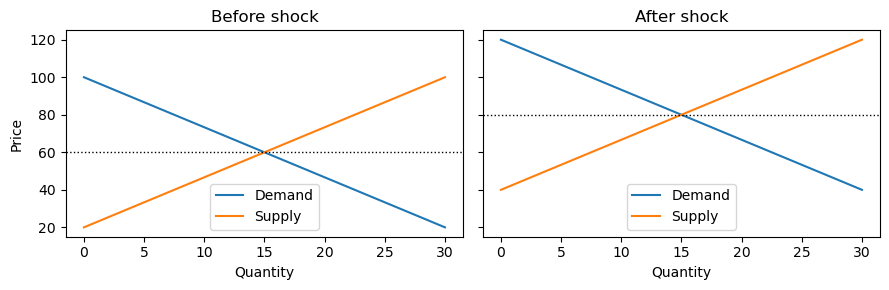

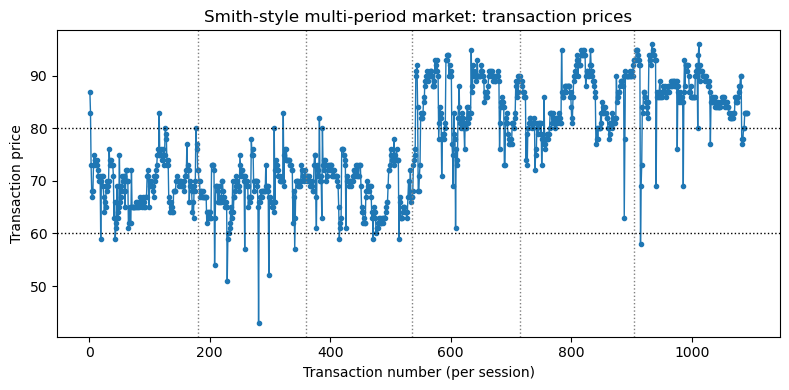

In [8]:
tape_df, cfg = get_smith_market_with_trades(max_tries=10)
print("Number of trades:", len(tape_df))
display(tape_df.head())

plot_supply_demand(pre_eq=cfg['pre_eq_price'],
                   post_eq=cfg['post_eq_price'],
                   spread=40,
                   q_max=30)

plot_transaction_prices(tape_df, cfg)
